In [1]:
import os, sys
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [12]:

def build_gan(data_shape, noise_dim):
    w = data_shape[1] 
    h = data_shape[2]
    d = data_shape[3]
    
    generator = models.Sequential([
        layers.Dense(int(w/4) * int(h/4) * 128, input_shape=[noise_dim]),
        layers.Reshape([int(w/4), int(h/4), 128]),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                     activation="selu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(d, kernel_size=5, strides=2, padding="SAME",
                                     activation="tanh"),
    ])
    discriminator = models.Sequential([
        layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                            activation=layers.LeakyReLU(0.2),
                            input_shape=[w, h, d]),
        layers.Dropout(0.4),
        layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                            activation=layers.LeakyReLU(0.2)),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    
    gan = models.Sequential([generator, discriminator])
    
    return gan

In [19]:
def plot_generated_images(generator, seed):
    generated_images = generator.predict(seed)
    plot_multiple_images(generated_images, 4) 

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
    plt.show()

def get_dataset(x_data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(1000)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
    print(dataset)
    return dataset

def make_constants(noise_dim, batch_size):
    y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
    y2 = tf.constant([[1.]] * batch_size)
    seed = tf.random.normal(shape=[16, noise_dim])
    return y1, y2, seed


class GAN():
    def __init__(self, x_data, noise_dim=100, batch_size=32):
    
        self.x_data = x_data
        self.noise_dim = noise_dim
        self.batch_size= batch_size

        self.gan = build_gan(x_data.shape, noise_dim)
        self.generator, self.discriminator = self.gan.layers
        self.gan.summary()

        # When compile generator(gan), discriminator must not trainable!
        self.discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
        self.discriminator.trainable = False
        self.gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

    
    def fit(self, n_epochs):

        # Set data
        dataset = get_dataset(self.x_data, self.batch_size)

        # y1 : half '0' half '1' for discriminator train 
        # y2 : all '1' for generator train
        y1, y2, seed = make_constants(self.noise_dim, self.batch_size)
        plot_generated_images(self.generator, seed)

        # Train
        for epoch in range(n_epochs):
            print("Epoch {}/{}".format(epoch + 1, n_epochs))
            for images in dataset:
                # phase 1 - training the discriminator
                noise = tf.random.normal(shape=[self.batch_size, self.noise_dim])
                generated_images = self.generator.predict(noise)

                self.discriminator.trainable = True
                self.discriminator.train_on_batch(tf.concat([generated_images, images], axis=0), y1)

                # phase 2 - training the generator
                noise = tf.random.normal(shape=[self.batch_size, self.noise_dim])
                self.discriminator.trainable = False
                self.gan.train_on_batch(noise, y2)

            plot_generated_images(self.generator, seed)


In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1. 
x_train_dcgan.shape

(60000, 28, 28, 1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_16 (Sequential)   (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 1,053,186
Non-trainable params: 384
_________________________________________________________________


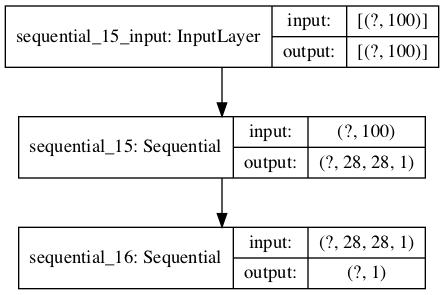

In [24]:
gan = GAN(x_train_dcgan)
plot_model(gan.gan, show_shapes=True)

<PrefetchDataset shapes: (32, 28, 28, 1), types: tf.float32>


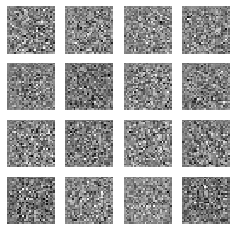

Epoch 1/5


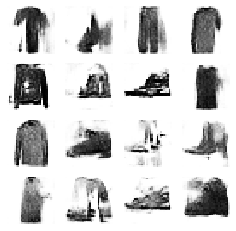

Epoch 2/5


KeyboardInterrupt: 

In [25]:
gan.fit(5)

<PrefetchDataset shapes: (32, 28, 28, 1), types: tf.float32>


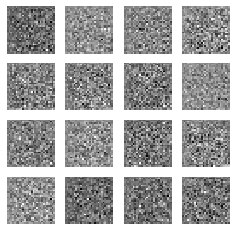

Epoch 1/5


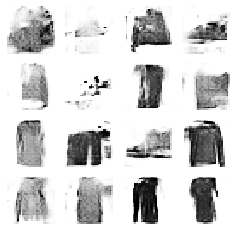

Epoch 2/5


KeyboardInterrupt: 

In [18]:
train_gan(gan, x_train_dcgan, 5)

In [26]:
gan.
